# Setup

In [1]:
DATA_VERSION = "2025-06-02"
DATA_FILE_NAME = f"consultation-documents-preprocessed-{DATA_VERSION}.parquet"
EXTRA_DOCUMENT_FEATURES_FILE_NAME = f"consultation-documents-features-{DATA_VERSION}.parquet"
EMBEDDINGS_FILE_NAME = (
    f"consultation-documents-embeddings-beginnings-openai-text-embedding-3-large-{DATA_VERSION}.parquet"
)

LANGUAGES = {
    "de",
    # "fr",
    # "it",
}

FROM_YEAR = 2000

INCLUDE_RULE_LABELS_IN_TRAINING = {
    "SYNOPTIC_TABLE",
    "LETTER",
    "RECIPIENT_LIST",
    "FINAL_REPORT",
}

CV_FOLDS = 5
# This fraction only applies to manually labelled OpenParlData documents. Many more documents make it
# into the training set, e.g. all Fedlex documents.
TEST_SIZE = 0.2
RANDOM_STATE = 2718
USE_TEST_SET = True

In [2]:
%load_ext autoreload
%autoreload 2

import logging
import os
import pathlib
import sys
from typing import Any

import dotenv
import matplotlib.pyplot as plt
import mlflow
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.metrics
import sklearn.model_selection
import sklearn.pipeline

REPOSITORY_ROOT = (pathlib.Path().cwd() / ".." / "..").resolve()
sys.path.append(str(REPOSITORY_ROOT))

In [3]:
import demokratis_ml.models.document_types.model
import demokratis_ml.models.document_types.preprocessing
from research.document_types import document_title_rule_model, training_split
from research.lib import data_access, plotting, utils

In [4]:
logging.basicConfig(level=logging.INFO, format="%(levelname)s %(name)s: %(message)s")

In [5]:
dotenv.load_dotenv()

True

In [6]:
if os.environ.get("MLFLOW_TRACKING_USERNAME") and os.environ.get("MLFLOW_TRACKING_PASSWORD"):
    mlflow.set_tracking_uri("https://mlflow.ml1.demokratis.ch/")
else:
    logging.warning("MLflow credentials not found, will track locally.")
    mlflow.set_tracking_uri("sqlite:///mlruns.db")

mlflow.set_experiment("VM_document_type_classifier")

if run := mlflow.active_run():
    logging.warning("Run = %s is already active, closing it.", run.info.run_name)
    mlflow.end_run()
run = mlflow.start_run()
print("Starting run:", run.info.run_name)
mlflow.log_param("data_version", DATA_VERSION)
mlflow.log_param("input_file", DATA_FILE_NAME)
mlflow.log_param("extra_features_file", EXTRA_DOCUMENT_FEATURES_FILE_NAME)
mlflow.log_param("embeddings_file", EMBEDDINGS_FILE_NAME)
mlflow.log_param("languages", LANGUAGES)
mlflow.log_param("from_year", FROM_YEAR)
mlflow.log_param("cv_folds", CV_FOLDS)
mlflow.log_param("test_size", TEST_SIZE)
mlflow.log_param("random_state", RANDOM_STATE)
mlflow.log_param("include_rule_labels_in_training", sorted(INCLUDE_RULE_LABELS_IN_TRAINING))
mlflow.log_param("merge_classes", demokratis_ml.models.document_types.preprocessing.MERGE_CLASSES)

mlflow.sklearn.autolog()

Starting run: rambunctious-ram-68


2025/06/04 09:58:58 WARNING mlflow.utils.autologging_utils: MLflow sklearn autologging is known to be compatible with 0.24.1 <= scikit-learn <= 1.5.2, but the installed version is 1.6.0. If you encounter errors during autologging, try upgrading / downgrading scikit-learn to a compatible version, or try upgrading MLflow.


# Input data preparation

## Get all dataframes

In [7]:
PREPROCESSED_DATA_FILE = REPOSITORY_ROOT / "data" / "dataframes" / DATA_FILE_NAME
data_access.ensure_dataframe_is_available(PREPROCESSED_DATA_FILE)

FEATURES_DATA_FILE = REPOSITORY_ROOT / "data" / "dataframes" / EXTRA_DOCUMENT_FEATURES_FILE_NAME
data_access.ensure_dataframe_is_available(FEATURES_DATA_FILE)

EMBEDDINGS_DATA_FILE = REPOSITORY_ROOT / "data" / "dataframes" / EMBEDDINGS_FILE_NAME
data_access.ensure_dataframe_is_available(EMBEDDINGS_DATA_FILE)

INFO ensure_dataframe_is_available: File /Users/vita/Code/demokratis/demokratis-ml/data/dataframes/consultation-documents-preprocessed-2025-06-02.parquet already exists locally.
INFO ensure_dataframe_is_available: File /Users/vita/Code/demokratis/demokratis-ml/data/dataframes/consultation-documents-features-2025-06-02.parquet already exists locally.
INFO ensure_dataframe_is_available: File /Users/vita/Code/demokratis/demokratis-ml/data/dataframes/consultation-documents-embeddings-beginnings-openai-text-embedding-3-large-2025-06-02.parquet already exists locally.


In [8]:
df_docs = data_access.load_consultation_documents(
    PREPROCESSED_DATA_FILE, only_languages=LANGUAGES, starting_year=FROM_YEAR
)
df_docs

,document_id,consultation_id,consultation_start_date,consultation_end_date,consultation_title,consultation_description,document_source_url,consultation_url,consultation_topics,consultation_internal_tags,...,organisation_id,organisation_name,political_body,latest_stored_file_id,document_source,consultation_topics_label_source,document_content_plain,stored_file_path,stored_file_mime_type,stored_file_hash
0,1,1,2021-10-01,2022-01-17,Verordnung des BAZG über die Bekämpfung von G...,Mit der am 19. März 2021 durch das Parlament b...,https://fedlex.data.admin.ch/filestore/fedlex....,https://www.demokratis.ch/vernehmlassung/7bt3hz2w,"[administration, finance, security]","[{'created_at': 2024-11-04 15:11:24, 'name': '...",...,41,Bundesamt für Zoll und Grenzsicherheit,ch,7780,fedlex,manual,«$$e-seal» \n«$$QrCode» \n \n2021-… \n«%ASFF_Y...,2024/1/1/1CM3wffPbDu7fUxY1BS22e.pdf,application/pdf,b8816738ad84d806e55723a313613097bed2752f
3,4,1,2021-10-01,2022-01-17,Verordnung des BAZG über die Bekämpfung von G...,Mit der am 19. März 2021 durch das Parlament b...,https://fedlex.data.admin.ch/filestore/fedlex....,https://www.demokratis.ch/vernehmlassung/7bt3hz2w,"[administration, finance, security]","[{'created_at': 2024-11-04 15:11:24, 'name': '...",...,41,Bundesamt für Zoll und Grenzsicherheit,ch,7783,fedlex,manual,Eidgenössisches Finanzdepartement EFD \nEidgen...,2024/1/4/1CM3wfhvda7QqrdPBrFGXj.pdf,application/pdf,d47bb05bc7f135a0b850702336ecca328f7dafce
6,7,1,2021-10-01,2022-01-17,Verordnung des BAZG über die Bekämpfung von G...,Mit der am 19. März 2021 durch das Parlament b...,https://fedlex.data.admin.ch/filestore/fedlex....,https://www.demokratis.ch/vernehmlassung/7bt3hz2w,"[administration, finance, security]","[{'created_at': 2024-11-04 15:11:24, 'name': '...",...,41,Bundesamt für Zoll und Grenzsicherheit,ch,7786,fedlex,manual,Eidgenössisches Finanzdepartement EFD \nEidgen...,2024/1/7/1CM3wfjqyn9SRWiSzYWSf3.pdf,application/pdf,fdcb391ccf2efd9b56a446e39284e3cceab5e4eb
9,10,1,2021-10-01,2022-01-17,Verordnung des BAZG über die Bekämpfung von G...,Mit der am 19. März 2021 durch das Parlament b...,https://fedlex.data.admin.ch/filestore/fedlex....,https://www.demokratis.ch/vernehmlassung/7bt3hz2w,"[administration, finance, security]","[{'created_at': 2024-11-04 15:11:24, 'name': '...",...,41,Bundesamt für Zoll und Grenzsicherheit,ch,7789,fedlex,manual,1. Oktober 2021 \n \n \n \n \nVerordnung des B...,2024/1/10/1CM3wfmi6ep9UK6E5T4bNu.pdf,application/pdf,b631111878a9eea5ae89bdc7ce85d86c609856a3
12,13,1,2021-10-01,2022-01-17,Verordnung des BAZG über die Bekämpfung von G...,Mit der am 19. März 2021 durch das Parlament b...,https://fedlex.data.admin.ch/filestore/fedlex....,https://www.demokratis.ch/vernehmlassung/7bt3hz2w,"[administration, finance, security]","[{'created_at': 2024-11-04 15:11:24, 'name': '...",...,41,Bundesamt für Zoll und Grenzsicherheit,ch,7792,fedlex,manual,Eidgenössisches Finanzdepartement EFD \nEidgen...,2024/1/13/1CM3wfoMZEhmu1hg9dbkvS.pdf,application/pdf,aa8dee571dc5bd912ba0adcc034dbda45f0b62c9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53494,55423,5146,2012-04-05,2012-05-31,Gesetz über die politischen Rechte; Teilrevision,,https://www.ag.ch/media/kanton-aargau/portal/a...,https://www.demokratis.ch/vernehmlassung/cd2b8x38,[],[],...,141,Regierungsrat des Kantons Aargau,ag,<NA>,openparldata,openparldata,\n Departement \nVolkswirtschaft und Inneres...,None,None,None
53495,55424,5146,2012-04-05,2012-05-31,Gesetz über die politischen Rechte; Teilrevision,,https://www.ag.ch/media/kanton-aargau/portal/a...,https://www.demokratis.ch/vernehmlassung/cd2b8x38,[],[],...,141,Regierungsrat des Kantons Aargau,ag,<NA>,openparldata,openparldata,Departement.wse<..--..**\n->U Volkswirtschaft ...,None,None,None
53496,55425,5146,2012-04-05,2012-05-31,Gesetz über die politischen Rechte; Teilrevision,,https://www.ag.ch/media/kanton-aargau/portal/a...,https://www.demokratis.ch/vernehmlassung/cd2b8x38,[],[

In [9]:
df_features = pd.read_parquet(FEATURES_DATA_FILE)
df_features

,,contains_table_on_first_page,count_pages,count_tables,count_pages_containing_tables,count_images,count_pages_containing_images,average_page_aspect_ratio
document_id,stored_file_hash,,,,,,,
1,b8816738ad84d806e55723a313613097bed2752f,False,26,0.0,0.0,0.0,0.0,0.704898
4,d47bb05bc7f135a0b850702336ecca328f7dafce,False,6,0.0,0.0,1.0,1.0,0.707098
7,fdcb391ccf2efd9b56a446e39284e3cceab5e4eb,False,2,0.0,0.0,1.0,1.0,0.707098
10,b631111878a9eea5ae89bdc7ce85d86c609856a3,False,15,0.0,0.0,13.0,6.0,0.707098
13,aa8dee571dc5bd912ba0adcc034dbda45f0b62c9,False,2,0.0,0.0,1.0,1.0,0.707098
...,...,...,...,...,...,...,...,...
55411,4dd82e826398db696ba59a0583f55a62eef3196c,False,24,0.0,0.0,2.0,2.0,0.707071
55414,3cb50a5e32bb8c525274ee718220e1c5a6ebd895,False,2,0.0,0.0,2.0,2.0,0.707098
55417,b1ac63c73715f799358378e0ac5a8b8cf0615c22,False,2,0.0,0.0,2.0,2.0,0.707098


In [10]:
df_embeddings = pd.read_parquet(EMBEDDINGS_DATA_FILE)
df_embeddings

,embedding
document_id,
1,"[0.01030252780765295, -0.014312159270048141, -..."
4,"[0.011395552195608616, 0.0014780974015593529, ..."
7,"[-0.005767590366303921, 0.002646328415721655, ..."
10,"[0.019797369837760925, -0.00907826703041792, -..."
13,"[-0.001758241094648838, 0.002000046195462346, ..."
...,...
55423,"[0.01773596927523613, -0.02248694933950901, -0..."
55424,"[0.017001070082187653, -0.02505420707166195, -..."
55425,"[0.0036743315868079662, -0.010835361666977406,..."


In [11]:
embedding_dimension = df_embeddings["embedding"].iloc[0].shape[0]
print("Embedding dimension:", embedding_dimension)

Embedding dimension: 3072


## Preprocess

In [12]:
df_input = demokratis_ml.models.document_types.preprocessing.create_input_dataframe(
    df_docs,
    df_extra_features=df_features,
    df_embeddings=df_embeddings,
)

INFO document_types.preprocessing: Dropping 1268 documents (5.4%) with empty texts
/Users/vita/Code/demokratis/demokratis-ml/demokratis_ml/models/document_types/features.py:50: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  df["consultation_start_timestamp"] = df["consultation_start_date"].view("int64") // 10**9
INFO document_types.features: 5278 rows (23.7%) were lost due to missing features. Remaining rows: 17035. 14 columns were added.
INFO document_types.features: Lost documents by political_body/year:
year            2007  2008  2009  2010  2011  2012  2013  2014  2015  2016  2017  2018  2019  2020  2021  2022  2023  2024   Total
political_body                                                                                                                    
ag                 0     0     0     0     0    67    17    52    27    13    62     3    59    75    59    57     5     3   499.0
ai  

## Split

In [13]:
df_input_train, df_input_test = training_split.train_test_split(
    df_input,
    random_state=RANDOM_STATE,
    test_size=TEST_SIZE,
    include_rule_labels_in_training=INCLUDE_RULE_LABELS_IN_TRAINING,
    stratify_by_canton=False,
)

INFO document_title_rule_model: 0.00% of documents already have labels
INFO document_title_rule_model: Labelled 0.25% by rule: canton=<any>, title^=adressliste => type=RECIPIENT_LIST
INFO document_title_rule_model: Labelled 2.93% by rule: canton=<any>, title^=adressatenliste => type=RECIPIENT_LIST
INFO document_title_rule_model: Labelled 0.16% by rule: canton=<any>, title^=adressatenverzeichnis => type=RECIPIENT_LIST
INFO document_title_rule_model: Labelled 1.16% by rule: canton=<any>, title^=vernehmlassungsadressaten => type=RECIPIENT_LIST
INFO document_title_rule_model: Labelled 0.16% by rule: canton=<any>, title^=vernehmlassungsadressen => type=RECIPIENT_LIST
INFO document_title_rule_model: Labelled 0.00% by rule: canton=<any>, title^=verzeichnis der anhörungsadressaten => type=RECIPIENT_LIST
INFO document_title_rule_model: Labelled 0.00% by rule: canton=<any>, title^=liste der konsultationsadressatinnen und konsultationsadressaten => type=RECIPIENT_LIST
INFO document_title_rule_mod

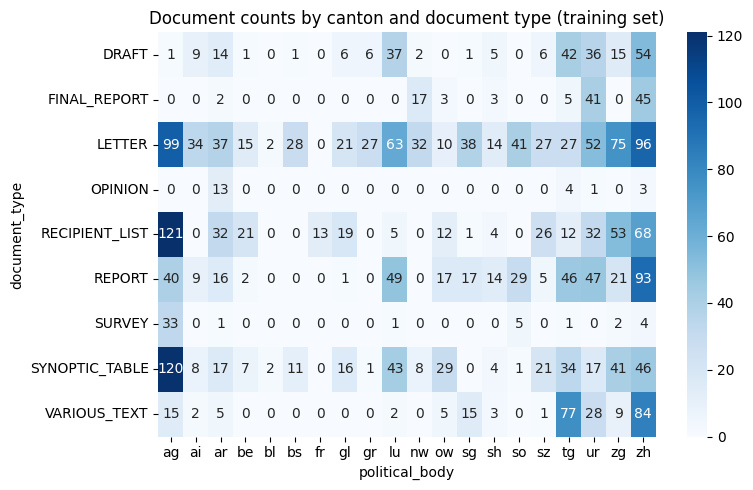

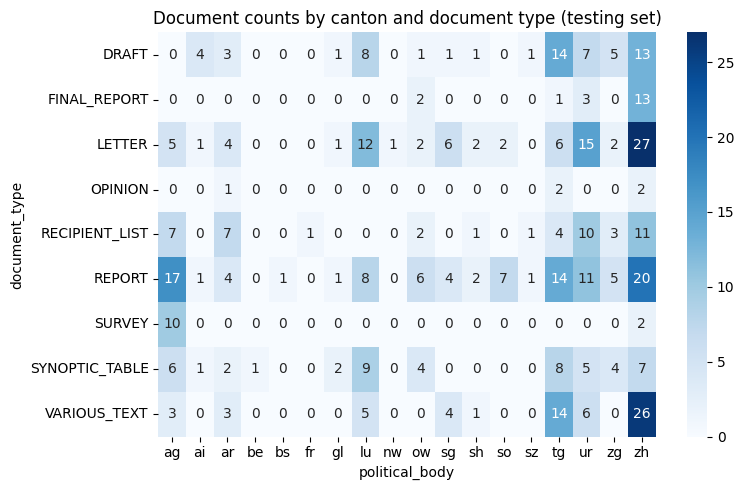

In [14]:
def plot_documents_per_canton(df: pd.DataFrame, set_name: str) -> None:
    df = df[df["political_body"] != "ch"]
    count_matrix = pd.crosstab(df["document_type"], df["political_body"])
    count_matrix = count_matrix.fillna(0)
    plt.figure(figsize=(8, 5))
    sns.heatmap(count_matrix, annot=True, fmt="g", cmap="Blues")
    plt.title(f"Document counts by canton and document type ({set_name} set)")
    plt.tight_layout()
    plt.show()


plot_documents_per_canton(df_input_train, "training")
plot_documents_per_canton(df_input_test, "testing")

In [15]:
display(df_input_train["document_type_label_source"].value_counts())
display(df_input_train["document_type"].value_counts())

document_type_label_source
fedlex    11654
manual     1762
rule        893
Name: count, dtype: int64

document_type
LETTER            3102
DRAFT             2927
REPORT            2411
RECIPIENT_LIST    2068
FINAL_REPORT      1740
OPINION            804
VARIOUS_TEXT       647
SYNOPTIC_TABLE     540
SURVEY              70
DECISION             0
LINK                 0
PRESS_RELEASE        0
RESPONSE_FORM        0
Name: count, dtype: int64

In [16]:
display(df_input_test["document_type_label_source"].value_counts())
display(df_input_test["document_type"].value_counts())

document_type_label_source
manual    441
Name: count, dtype: int64

document_type
REPORT            102
LETTER             86
VARIOUS_TEXT       62
DRAFT              59
SYNOPTIC_TABLE     49
RECIPIENT_LIST     47
FINAL_REPORT       19
SURVEY             12
OPINION             5
DECISION            0
LINK                0
PRESS_RELEASE       0
RESPONSE_FORM       0
Name: count, dtype: int64

In [17]:
mlflow.log_param("train_samples_count", len(df_input_train))
mlflow.log_param("test_samples_count", len(df_input_test))

441

# Data exploration

## Data representation

In [18]:
print("df_input_train labels:")
df_input_train.groupby("document_type_label_source")["document_type"].value_counts()

df_input_train labels:


document_type_label_source  document_type 
fedlex                      DRAFT             2691
                            LETTER            2364
                            REPORT            2005
                            RECIPIENT_LIST    1649
                            FINAL_REPORT      1624
                            OPINION            783
                            VARIOUS_TEXT       401
                            SYNOPTIC_TABLE     114
                            SURVEY              23
                            DECISION             0
                            LINK                 0
                            PRESS_RELEASE        0
                            RESPONSE_FORM        0
manual                      REPORT             406
                            LETTER             342
                            VARIOUS_TEXT       246
                            DRAFT              236
                            SYNOPTIC_TABLE     199
                            RECIPIENT_L

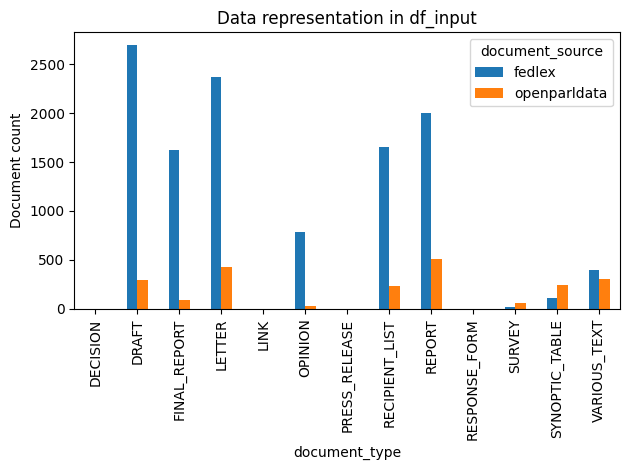

document_source,fedlex,openparldata
document_type,,
DECISION,0,0
DRAFT,2691,295
FINAL_REPORT,1624,94
LETTER,2364,428
LINK,0,0
OPINION,783,26
PRESS_RELEASE,0,0
RECIPIENT_LIST,1649,237
REPORT,2005,508


In [19]:
repr_table = df_input.pivot_table(
    index="document_type", columns="document_source", aggfunc="size", fill_value=0, observed=False
)
display(
    plotting.plot_and_log(
        repr_table.plot,
        "data_representation.png",
        title="Data representation in df_input",
        kind="bar",
        ylabel="Document count",
    )
)
display(repr_table)

## Extra features

In [20]:
print("contains_salutation:")
df_input.pivot_table(
    index="document_type",
    columns="document_source",
    values="contains_salutation",
    aggfunc="mean",
    fill_value=0,
    observed=False,
)

contains_salutation:


document_source,fedlex,openparldata
document_type,,
DRAFT,0.001115,0.000000
FINAL_REPORT,0.003695,0.042553
LETTER,0.985195,0.995327
OPINION,0.747126,0.692308
RECIPIENT_LIST,0.000000,0.000000
REPORT,0.012968,0.049213
SURVEY,0.000000,0.050847
SYNOPTIC_TABLE,0.000000,0.000000
VARIOUS_TEXT,0.014963,0.009740


### Keyword-like features

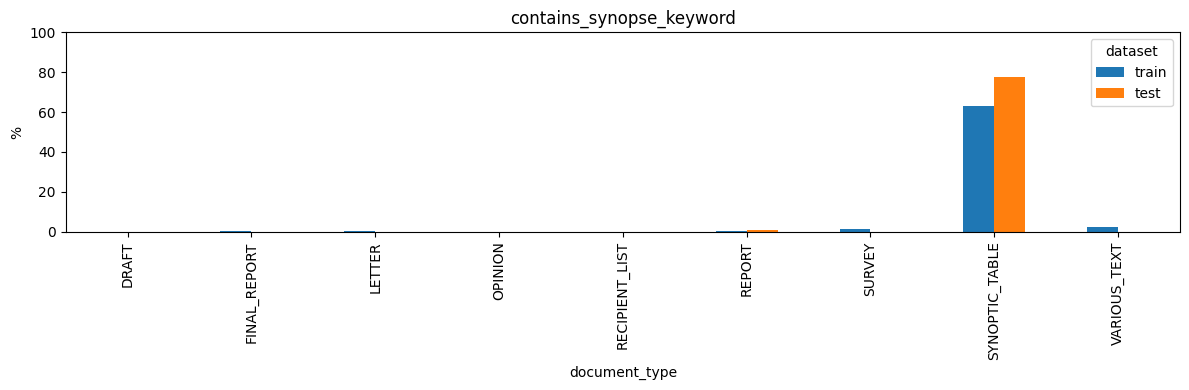

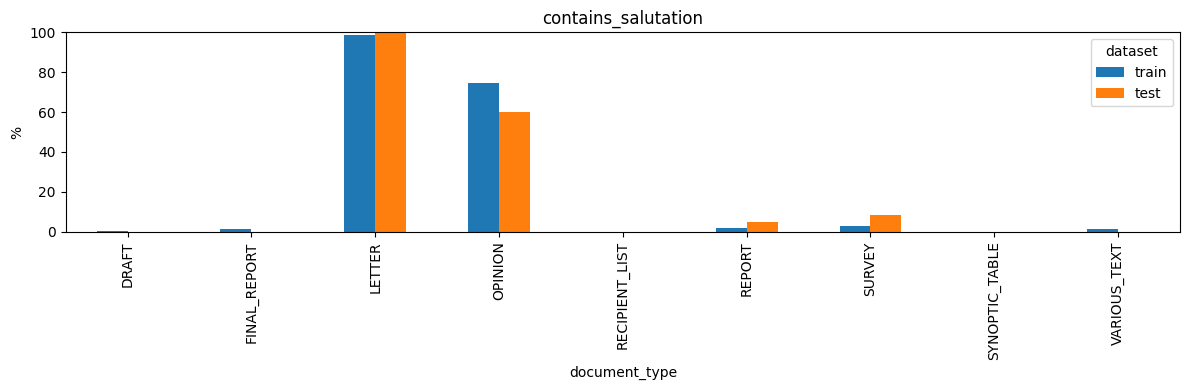

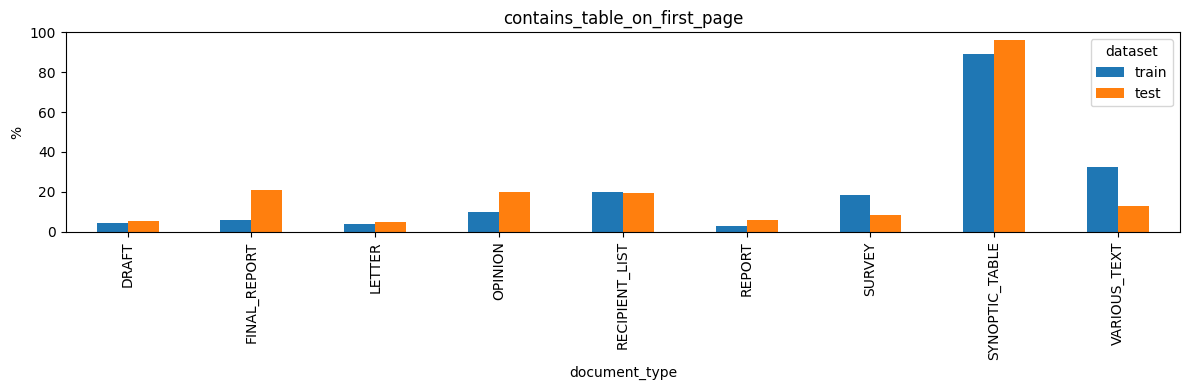

In [21]:
def plot_binary_feature_across_document_types(df_train: pd.DataFrame, df_test: pd.DataFrame, feature_name: str) -> None:
    df = pd.concat(
        [
            df_train[["document_type", feature_name]].assign(dataset="train"),
            df_test[["document_type", feature_name]].assign(dataset="test"),
        ],
        axis=0,
    )
    pivot_table = df.pivot_table(
        index="document_type",
        columns="dataset",
        values=feature_name,
        aggfunc=lambda x: 100 * x.mean(),
        fill_value=0,
        observed=False,
    )
    pivot_table = pivot_table[["train", "test"]]  # Ensure "train" comes first
    pivot_table.plot(
        kind="bar",
        figsize=(12, 4),
        title=feature_name,
        ylabel="%",
        ylim=(0, 100),
    )
    plt.tight_layout()
    plt.show()


plot_binary_feature_across_document_types(df_input_train, df_input_test, "contains_synopse_keyword")
plot_binary_feature_across_document_types(df_input_train, df_input_test, "contains_salutation")
plot_binary_feature_across_document_types(df_input_train, df_input_test, "contains_table_on_first_page")

In [22]:
def plot_feature_distribution_across_document_types(
    df_train: pd.DataFrame, df_test: pd.DataFrame, feature_name: str, clip_y: None | tuple[int, int] = None
) -> None:
    plt.figure(figsize=(14, 5))
    df = pd.concat(
        [
            df_train[["document_type", feature_name]].assign(dataset="train"),
            df_test[["document_type", feature_name]].assign(dataset="test"),
        ],
        axis=0,
    )
    ax = sns.violinplot(
        data=df,
        x="document_type",
        y=feature_name,
        hue="dataset",
        order=sorted(df["document_type"].unique()),
        # inner="box",  # Show boxplot inside violin
        inner=None,  # Show only violin
        split=True,
        linewidth=0.1,
    )
    plt.xticks(rotation=90)
    if clip_y:
        sample = df[feature_name].dropna()
        ax.set_ylim(*np.percentile(sample, clip_y))
        plt.title(f"{feature_name} (clipped to {clip_y[0]}-{clip_y[1]}th percentile)")
    else:
        plt.title(feature_name)
    plt.tight_layout()
    plt.show()

### Page count, aspect ratio

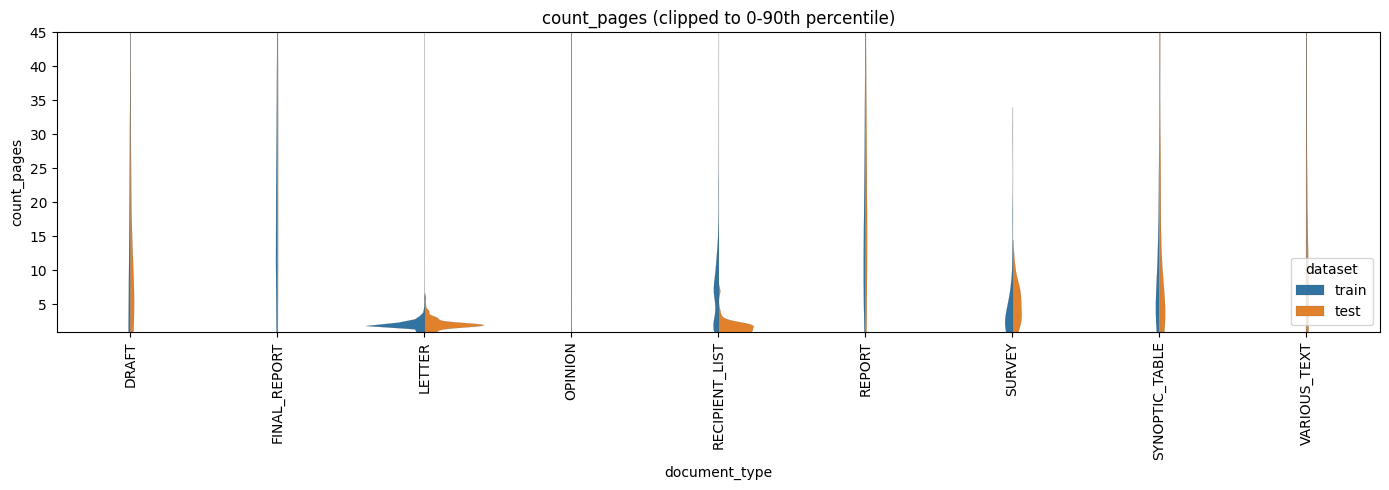

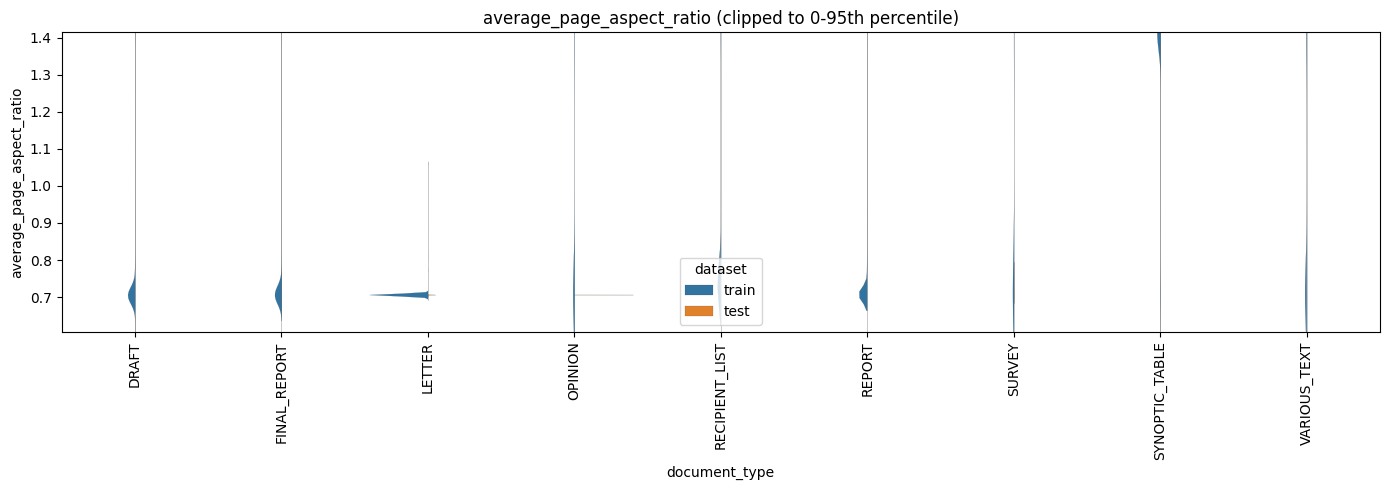

In [23]:
plot_feature_distribution_across_document_types(df_input_train, df_input_test, "count_pages", clip_y=(0, 90))
plot_feature_distribution_across_document_types(
    df_input_train, df_input_test, "average_page_aspect_ratio", clip_y=(0, 95)
)

In [24]:
pd.concat([df_input_train.assign(dataset="train"), df_input_test.assign(dataset="test")], axis=0).pivot_table(
    index="document_type",
    columns="dataset",
    values="count_pages",
    aggfunc=["mean", "std"],
    fill_value=0,
    observed=False,
)

mean                    std            
dataset              test       train       test       train
document_type                                               
DRAFT           10.389831   13.695934  12.424971   45.748523
FINAL_REPORT    51.368421   26.964943  54.632317   44.395647
LETTER           2.186047    2.162476   0.847302    1.411716
OPINION         52.600000  364.559701  57.609027  730.508631
RECIPIENT_LIST   1.744681    7.063346   1.031421    5.406938
REPORT          25.235294   24.629200  34.155781   29.624472
SURVEY           5.083333    4.185714   2.906367    4.719042
SYNOPTIC_TABLE   7.836735   10.746296   8.721016   13.351689
VARIOUS_TEXT    14.112903   21.384853  24.037610  155.268045

In [25]:
pd.concat([df_input_train.assign(dataset="train"), df_input_test.assign(dataset="test")], axis=0).pivot_table(
    index="document_type",
    columns="dataset",
    values="average_page_aspect_ratio",
    aggfunc=["mean", "std"],
    fill_value=0,
    observed=False,
)

mean                 std          
dataset             test     train      test     train
document_type                                         
DRAFT           0.731394  0.729097  0.130508  0.112108
FINAL_REPORT    0.963886  0.728267  0.320823  0.106711
LETTER          0.707078  0.707843  0.000685  0.014662
OPINION         0.707120  0.827394  0.000038  0.250516
RECIPIENT_LIST  0.753544  0.769123  0.174669  0.180264
REPORT          0.757995  0.724239  0.138658  0.089185
SURVEY          0.712567  0.831024  0.018946  0.261209
SYNOPTIC_TABLE  1.378153  1.368125  0.144824  0.168410
VARIOUS_TEXT    0.753695  0.877596  0.157944  0.302252

### Tables

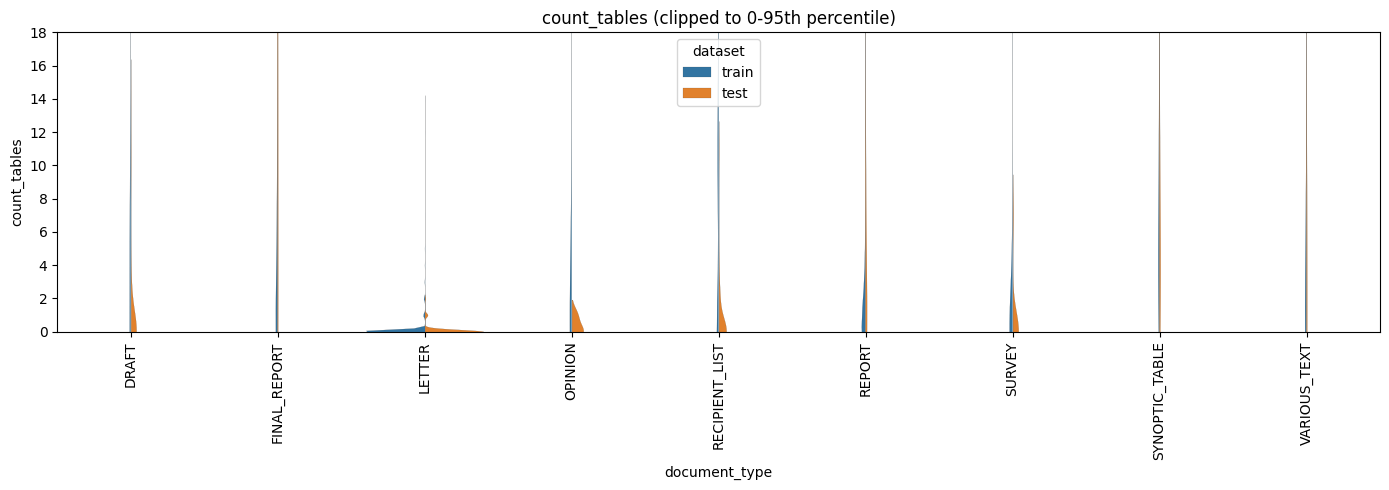

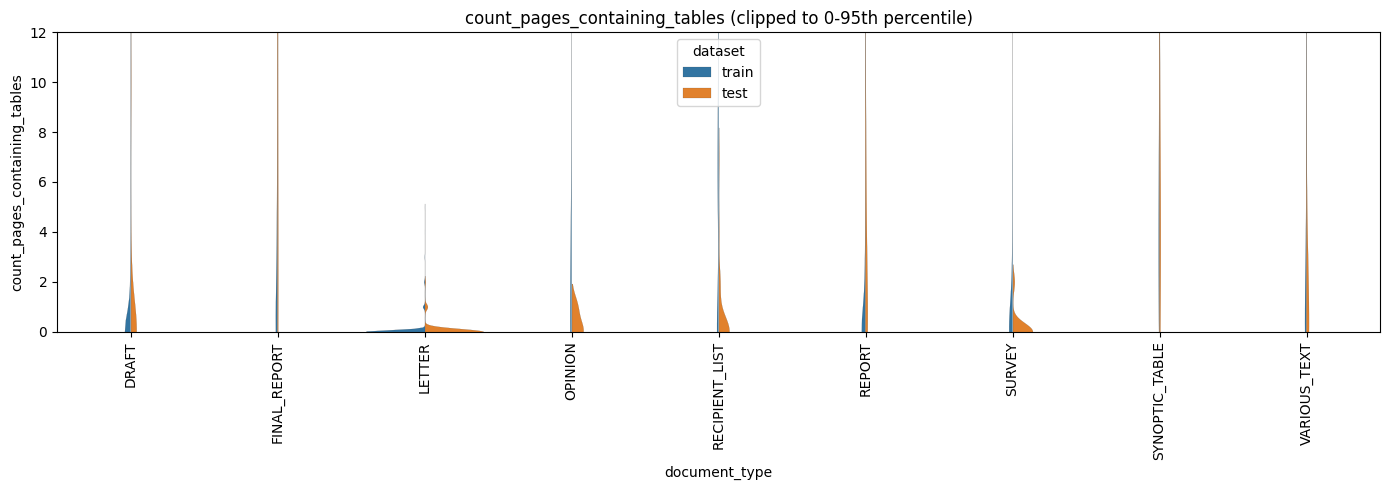

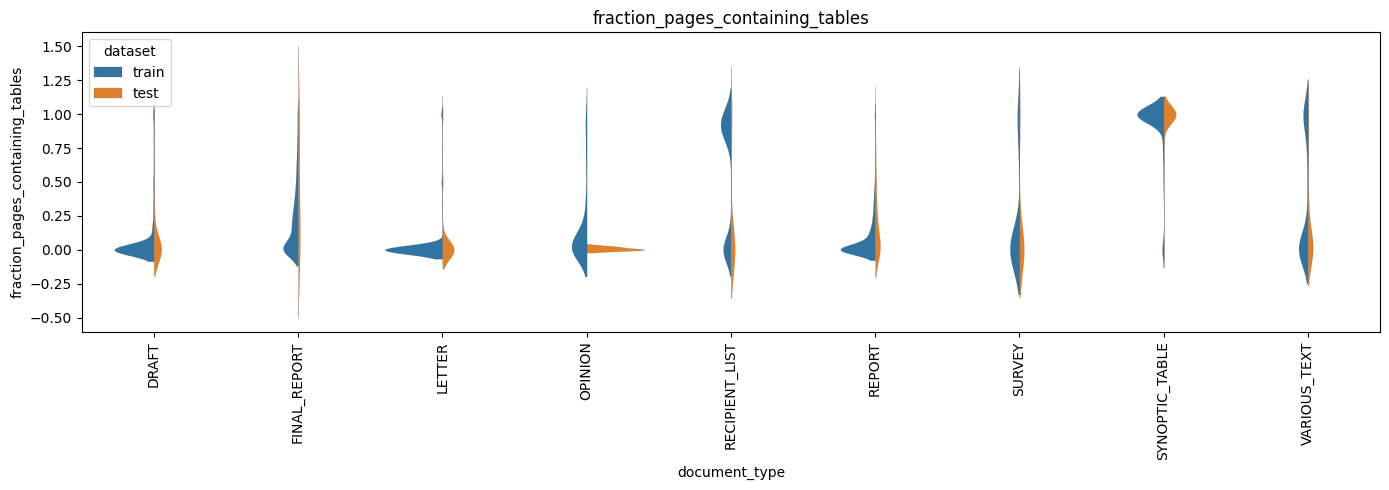

In [26]:
plot_feature_distribution_across_document_types(df_input_train, df_input_test, "count_tables", clip_y=(0, 95))
plot_feature_distribution_across_document_types(
    df_input_train, df_input_test, "count_pages_containing_tables", clip_y=(0, 95)
)
plot_feature_distribution_across_document_types(df_input_train, df_input_test, "fraction_pages_containing_tables")

### Images

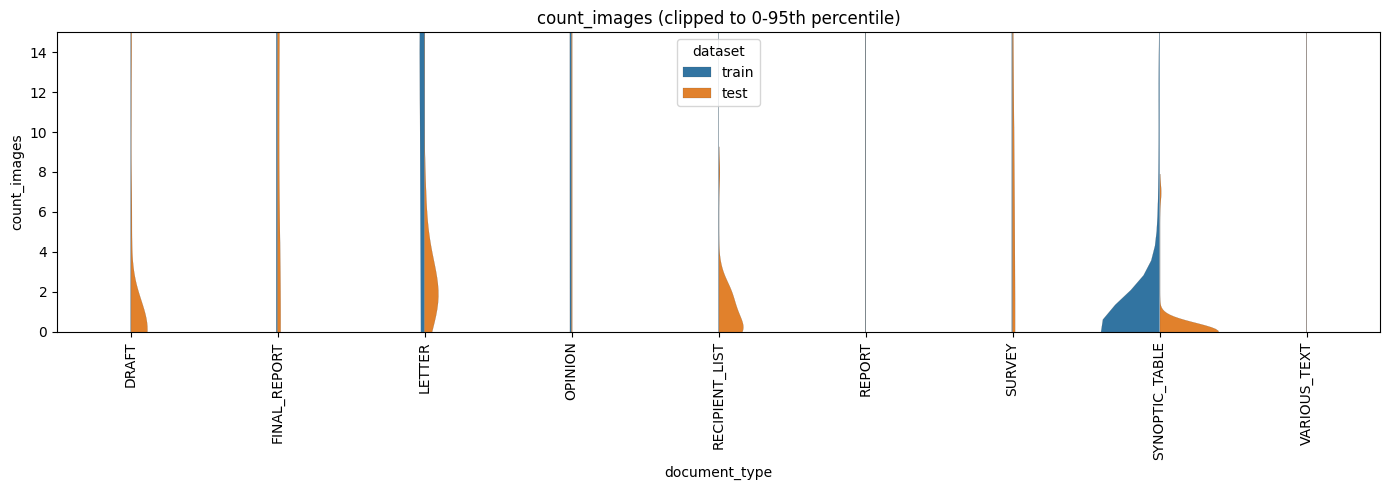

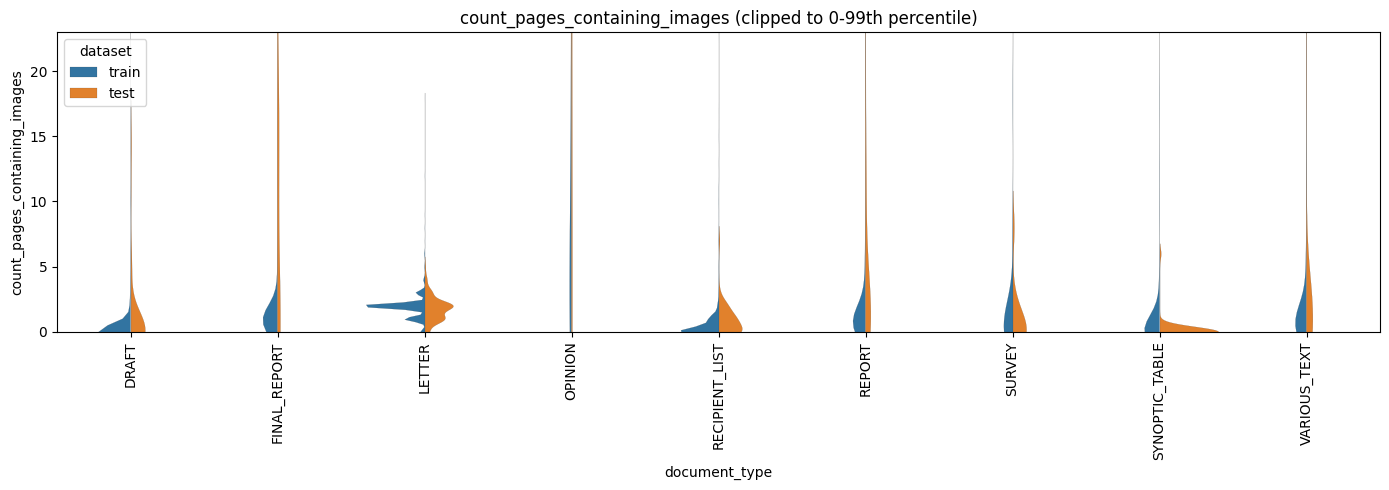

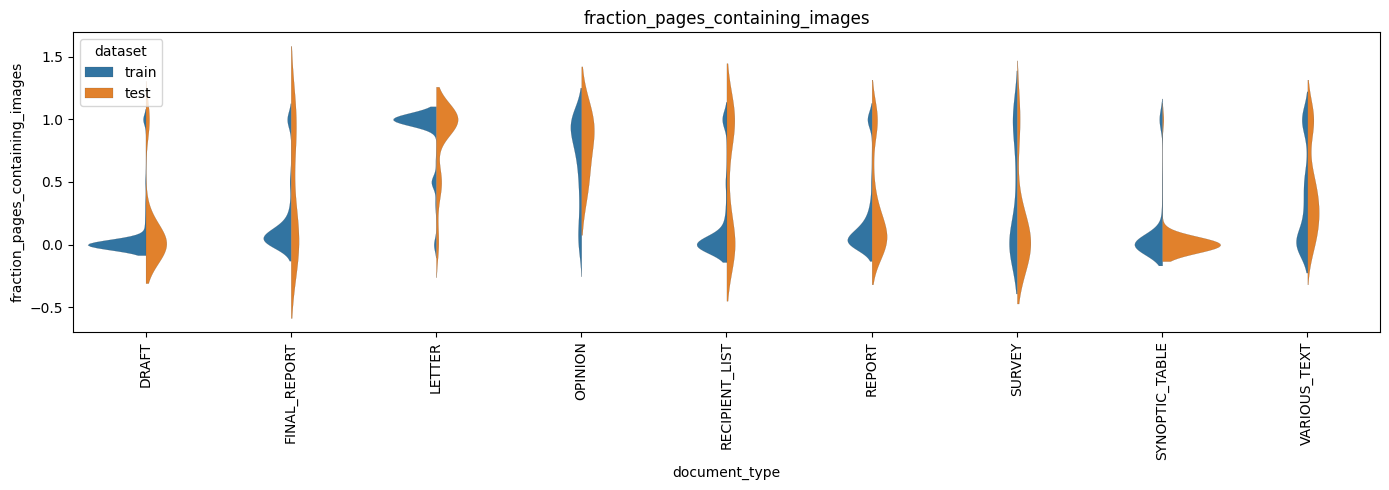

In [27]:
plot_feature_distribution_across_document_types(df_input_train, df_input_test, "count_images", clip_y=(0, 95))
plot_feature_distribution_across_document_types(
    df_input_train, df_input_test, "count_pages_containing_images", clip_y=(0, 99)
)
plot_feature_distribution_across_document_types(df_input_train, df_input_test, "fraction_pages_containing_images")

### Time features

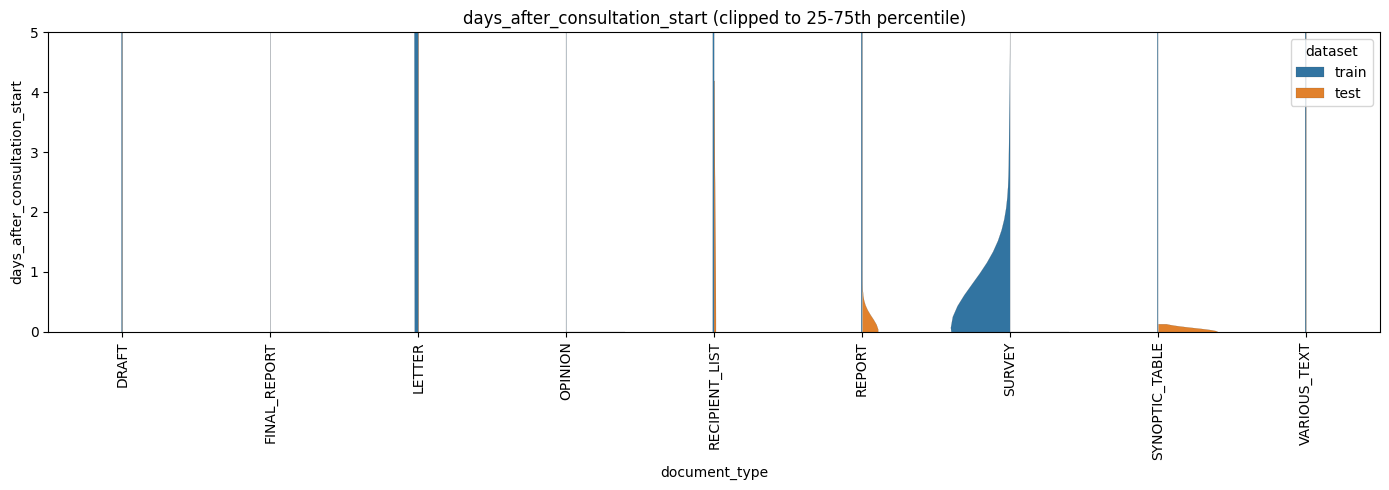

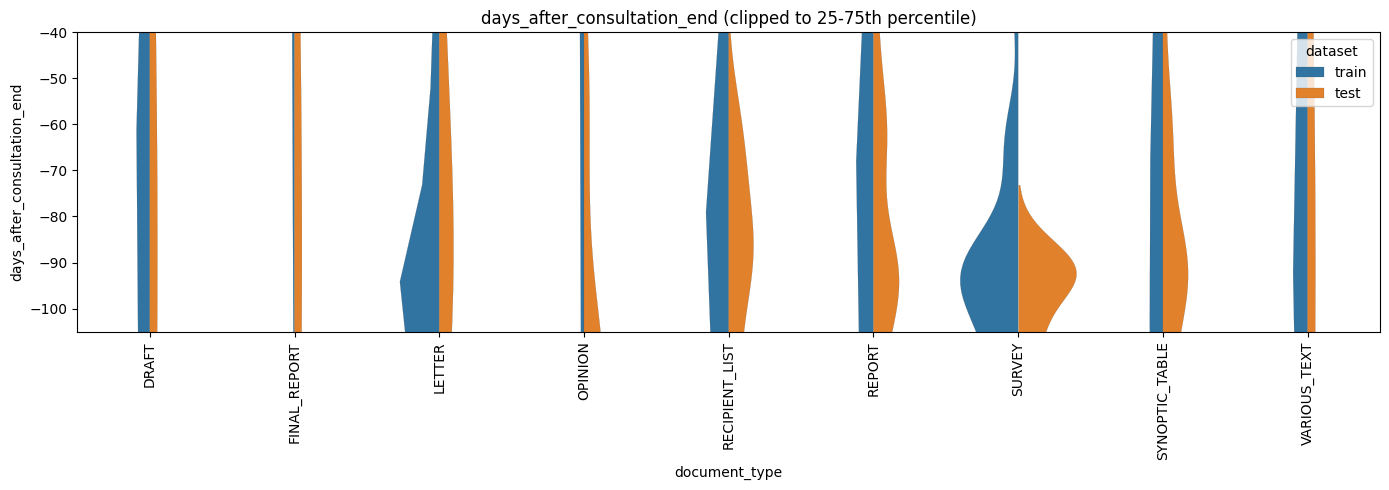

In [28]:
plot_feature_distribution_across_document_types(
    df_input_train,
    df_input_test,
    "days_after_consultation_start",
    clip_y=(25, 75),
)
plot_feature_distribution_across_document_types(
    df_input_train,
    df_input_test,
    "days_after_consultation_end",
    clip_y=(25, 75),
)

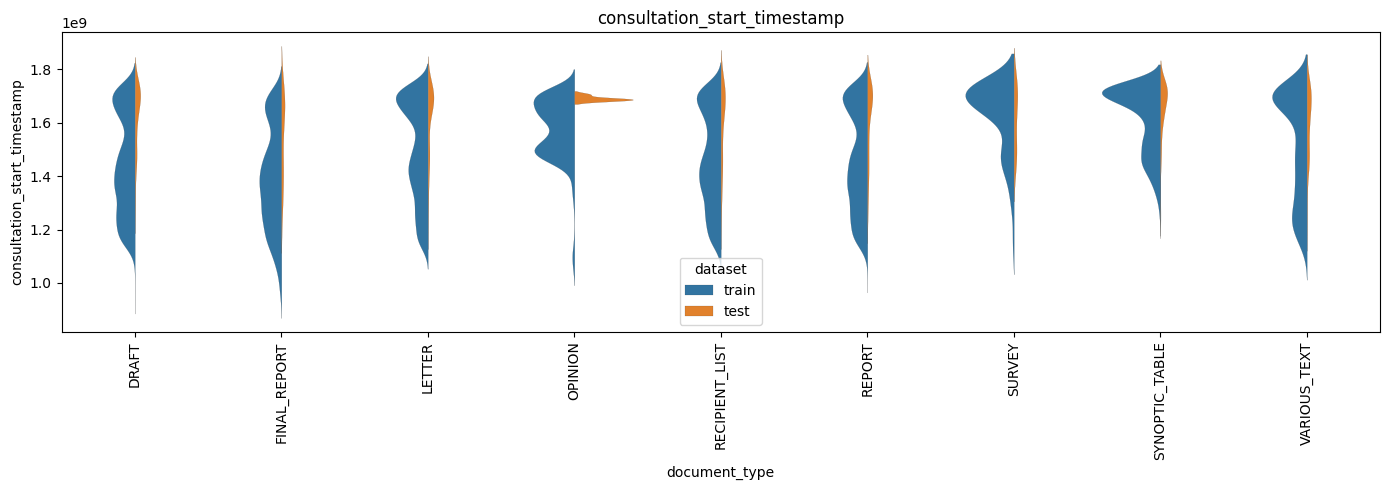

In [29]:
plot_feature_distribution_across_document_types(
    df_input_train,
    df_input_test,
    "consultation_start_timestamp",
    # clip_y=(25, 75),
)

<!-- # Classification -->

In [30]:
mlflow.log_param("extra_feature_columns", sorted(demokratis_ml.models.document_types.model.EXTRA_FEATURE_COLUMNS))
mlflow.log_param(
    "extra_categorical_feature_columns", sorted(demokratis_ml.models.document_types.model.EXTRA_CATEGORICAL_COLUMNS)
)

X_train, y_train = demokratis_ml.models.document_types.model.create_matrices(df_input_train)
X_test, y_test = demokratis_ml.models.document_types.model.create_matrices(df_input_test)

print("train", X_train.shape)
print("test", X_test.shape)

train (14309, 3081)
test (441, 3081)


In [31]:
classifier = demokratis_ml.models.document_types.model.create_classifier(
    embedding_dimension=embedding_dimension,
    random_state=RANDOM_STATE,
)
classifier

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('embeddings',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler()),
                                                                  ('pca',
                                                                   PCA(n_components=20,
                                                                       random_state=2718))]),
                                                  slice(0, 3072, None)),
                                                 ('extra_features',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  slice(3072, 3081, None))])),
                ('logisticregression', LogisticRegression(max_iter=2000))])

In [32]:
def explained_variance_scorer(pipeline: sklearn.pipeline.Pipeline, X: Any, y: Any = None) -> np.float64:
    pca = demokratis_ml.models.document_types.model.get_pca_step(pipeline)
    if pca is None:
        return np.nan
    explained_variance = np.sum(pca.explained_variance_ratio_)
    return explained_variance


scoring = {
    "precision": "precision_weighted",
    "recall": "recall_weighted",
    "f1": "f1_weighted",
    "pca_explained_variance": explained_variance_scorer,
    "accuracy": "accuracy",
    "top_k_accuracy": "top_k_accuracy",
    # "top_k_accuracy": sklearn.metrics.make_scorer(sklearn.metrics.top_k_accuracy_score, k=3),
}

scores_docs = sklearn.model_selection.cross_validate(
    classifier,
    X=X_train,
    y=y_train,
    cv=sklearn.model_selection.StratifiedKFold(
        n_splits=CV_FOLDS,
        shuffle=True,
        random_state=RANDOM_STATE,
    ),
    scoring=scoring,
)
scores_docs

{'fit_time': array([5.61985898, 6.50205708, 5.752069  , 5.03858519, 5.41118813]),
 'score_time': array([0.08763695, 0.09857392, 0.11707306, 0.08697581, 0.09154701]),
 'test_precision': array([0.9140624 , 0.92390687, 0.92244176, 0.91416495, 0.91769208]),
 'test_recall': array([0.91823899, 0.92837177, 0.92557652, 0.9185884 , 0.9217057 ]),
 'test_f1': array([0.91523904, 0.92446076, 0.9233525 , 0.91541341, 0.91872663]),
 'test_pca_explained_variance': array([0.4130649 , 0.41294256, 0.41300309, 0.4131816 , 0.41310433]),
 'test_accuracy': array([0.91823899, 0.92837177, 0.92557652, 0.9185884 , 0.9217057 ]),
 'test_top_k_accuracy': array([0.96785465, 0.97134871, 0.96925227, 0.96890287, 0.96959105])}

## CV evaluation

In [33]:
utils.log_metrics(
    **{k.replace("test_", "cv_"): np.round(np.mean(v), 4) for k, v in scores_docs.items() if k.startswith("test_")}
)

{'cv_accuracy': 0.9225,
 'cv_f1': 0.9194,
 'cv_pca_explained_variance': 0.4131,
 'cv_precision': 0.9185,
 'cv_recall': 0.9225,
 'cv_top_k_accuracy': 0.9694}


### Use subsets of the training set to re-train and evaluate. This gives us a single model to run reports on. 

In [34]:
cv_test_splitter = sklearn.model_selection.StratifiedShuffleSplit(
    n_splits=1,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
)

cv_train_index, cv_test_index = next(cv_test_splitter.split(X=X_train, y=y_train))

X_cv_train = X_train[cv_train_index]
y_cv_train = y_train.iloc[cv_train_index]
X_cv_test = X_train[cv_test_index]
y_cv_test = y_train.iloc[cv_test_index]

In [35]:
classifier.fit(X_cv_train, y_cv_train)
cv_test_predictions = classifier.predict(X_cv_test)

2025/06/04 09:59:44 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'
2025/06/04 09:59:56 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


                precision    recall  f1-score   support

         DRAFT       0.89      0.92      0.90       585
  FINAL_REPORT       0.95      0.95      0.95       348
        LETTER       0.99      1.00      0.99       621
       OPINION       0.91      0.92      0.92       161
RECIPIENT_LIST       0.99      0.99      0.99       414
        REPORT       0.89      0.93      0.91       482
        SURVEY       0.67      0.57      0.62        14
SYNOPTIC_TABLE       0.78      0.87      0.82       108
  VARIOUS_TEXT       0.63      0.34      0.44       129

      accuracy                           0.92      2862
     macro avg       0.86      0.83      0.84      2862
  weighted avg       0.92      0.92      0.92      2862



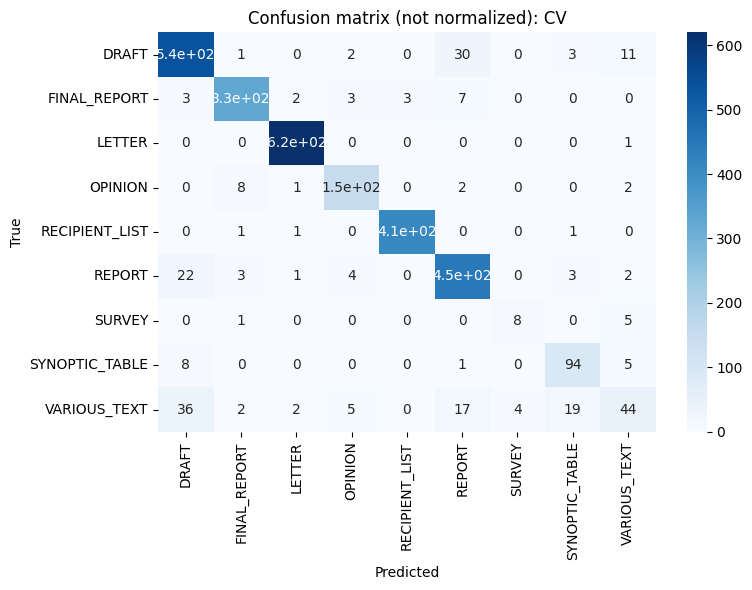

In [36]:
report = sklearn.metrics.classification_report(y_cv_test, cv_test_predictions, zero_division=np.nan)
mlflow.log_text(report, "cv_classification_report.txt")
print(report)
cm = plotting.plot_confusion_matrix_heatmap(y_cv_test, cv_test_predictions, title="CV")
mlflow.log_figure(cm, "cv_confusion_matrix.png")
display(cm)

### Feature importance (not implemented)

In [37]:
# explainer = shap.Explainer(classifier)  # .named_steps["logisticregression"])
# shap_values = explainer(X_cv_test)

# # visualize the first prediction's explanation
# shap.plots.waterfall(shap_values[0])


# def get_shap_values_for_complex_pipeline(pipeline, X_test):
#     # Extract preprocessing steps
#     column_transformer = pipeline.named_steps["columntransformer"]
#     classifier = pipeline.named_steps["logisticregression"]

#     # Transform a small batch of data for initialization
#     background_indices = np.random.choice(X_test.shape[0], 100, replace=False)
#     background_data = column_transformer.transform(X_test[background_indices])

#     # Create explainer with both model and background data
#     explainer = shap.KernelExplainer(classifier.predict, background_data)

#     # Transform the full test data
#     transformed_data = column_transformer.transform(X_test)

#     # Get SHAP values
#     shap_values = explainer.shap_values(transformed_data)

#     return shap_values


# Usage
# shap_values = get_shap_values_for_complex_pipeline(classifier, X_cv_test)
# shap_values


In [38]:
# importances = pd.Series(
#     classifier.named_steps["gradientboostingclassifier"].feature_importances_,
#     index=[f"embedding_{i:02d}" for i in range(20)] + extra_feature_columns,
# )
# importances.sort_values(ascending=False)

## Evaluation on the test set

2025/06/04 09:59:57 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'
2025/06/04 10:00:09 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


                precision    recall  f1-score   support

         DRAFT       0.79      0.78      0.79        59
  FINAL_REPORT       0.80      0.84      0.82        19
        LETTER       1.00      0.99      0.99        86
       OPINION       0.44      0.80      0.57         5
RECIPIENT_LIST       1.00      1.00      1.00        47
        REPORT       0.82      0.82      0.82       102
        SURVEY       1.00      0.67      0.80        12
SYNOPTIC_TABLE       0.94      0.98      0.96        49
  VARIOUS_TEXT       0.66      0.65      0.65        62

      accuracy                           0.86       441
     macro avg       0.83      0.84      0.82       441
  weighted avg       0.86      0.86      0.86       441



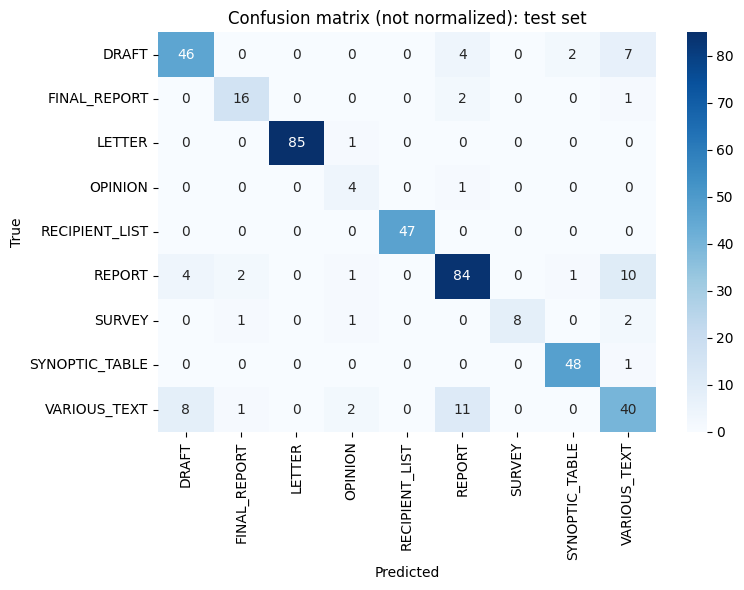

{'test_accuracy': 0.8571,
 'test_f1': 0.8578,
 'test_precision': 0.8617,
 'test_recall': 0.8571,
 'test_top_k_accuracy': 0.9388}


In [39]:
if USE_TEST_SET:
    # Training & OOS predictions
    classifier_test = demokratis_ml.models.document_types.model.create_classifier(
        embedding_dimension=embedding_dimension,
        random_state=RANDOM_STATE,
    )
    classifier_test.fit(X_train, y_train)
    y_test_predicted = classifier_test.predict(X_test)

    # Classification report
    report = sklearn.metrics.classification_report(
        y_test,
        y_test_predicted,
        zero_division=np.nan,
    )
    mlflow.log_text(report, "test_classification_report.txt")
    print(report)

    # Confusion matrix
    cm = plotting.plot_confusion_matrix_heatmap(y_test, y_test_predicted, title="test set")
    mlflow.log_figure(cm, "test_confusion_matrix.png")
    display(cm)

    # Metrics
    p_r_f1 = sklearn.metrics.precision_recall_fscore_support(
        y_test,
        y_test_predicted,
        average="weighted",
        zero_division=np.nan,
    )
    utils.log_metrics(
        test_precision=p_r_f1[0],
        test_recall=p_r_f1[1],
        test_f1=p_r_f1[2],
        test_accuracy=sklearn.metrics.accuracy_score(y_test, y_test_predicted),
        test_top_k_accuracy=sklearn.metrics.top_k_accuracy_score(y_test, classifier_test.predict_proba(X_test)),
    )

### Results per canton

In [40]:
df_eval = df_input_test.copy()
df_eval["document_type_predicted"] = y_test_predicted

for canton_code, df_canton in df_eval.groupby("political_body", observed=False):
    # Skip the "ch" political_body, which is the federal level and not a canton
    if canton_code == "ch":
        continue
    print(f"\n{'-' * 60}\n{canton_code}\n{'-' * 60}")
    if df_canton.empty:
        print("No data")
    else:
        report = sklearn.metrics.classification_report(
            df_canton["document_type"], df_canton["document_type_predicted"], zero_division=np.nan
        )
        print(report)


------------------------------------------------------------
ag
------------------------------------------------------------
                precision    recall  f1-score   support

  FINAL_REPORT       0.00       nan      0.00         0
        LETTER       1.00      1.00      1.00         5
       OPINION       0.00       nan      0.00         0
RECIPIENT_LIST       1.00      1.00      1.00         7
        REPORT       0.93      0.76      0.84        17
        SURVEY       1.00      0.80      0.89        10
SYNOPTIC_TABLE       1.00      0.83      0.91         6
  VARIOUS_TEXT       0.29      0.67      0.40         3

      accuracy                           0.83        48
     macro avg       0.65      0.84      0.63        48
  weighted avg       0.93      0.83      0.87        48


------------------------------------------------------------
ai
------------------------------------------------------------
                precision    recall  f1-score   support

         DRAFT  

## Comparison: rule-based model

In [41]:
# We must erase the true labels first because the rule-based model doesn't overwrite existing labels.
_df = df_input_test.copy()
_df.loc[:, "document_type"] = None
# Explicit class-merging step is needed because the rule-based model may output any class.
y_test_predicted_rules = demokratis_ml.models.document_types.preprocessing.merge_classes(
    document_title_rule_model.predict(_df), demokratis_ml.models.document_types.preprocessing.MERGE_CLASSES
)

INFO document_title_rule_model: 0.00% of documents already have labels
INFO document_title_rule_model: Labelled 0.00% by rule: canton=<any>, title^=adressliste => type=RECIPIENT_LIST
INFO document_title_rule_model: Labelled 2.27% by rule: canton=<any>, title^=adressatenliste => type=RECIPIENT_LIST
INFO document_title_rule_model: Labelled 0.23% by rule: canton=<any>, title^=adressatenverzeichnis => type=RECIPIENT_LIST
INFO document_title_rule_model: Labelled 1.59% by rule: canton=<any>, title^=vernehmlassungsadressaten => type=RECIPIENT_LIST
INFO document_title_rule_model: Labelled 0.23% by rule: canton=<any>, title^=vernehmlassungsadressen => type=RECIPIENT_LIST
INFO document_title_rule_model: Labelled 0.23% by rule: canton=<any>, title^=verzeichnis der anhörungsadressaten => type=RECIPIENT_LIST
INFO document_title_rule_model: Labelled 0.00% by rule: canton=<any>, title^=liste der konsultationsadressatinnen und konsultationsadressaten => type=RECIPIENT_LIST
INFO document_title_rule_mod

                precision    recall  f1-score   support

         DRAFT       0.75      1.00      0.86        49
  FINAL_REPORT       1.00      0.40      0.57         5
        LETTER       0.96      1.00      0.98        79
       OPINION        nan      0.00      0.00         1
RECIPIENT_LIST       1.00      1.00      1.00        41
        REPORT       0.94      0.88      0.91        90
        SURVEY       1.00      1.00      1.00        11
SYNOPTIC_TABLE       1.00      0.86      0.93        44
  VARIOUS_TEXT       1.00      0.89      0.94        27

      accuracy                           0.93       347
     macro avg       0.96      0.78      0.80       347
  weighted avg       0.94      0.93      0.93       347



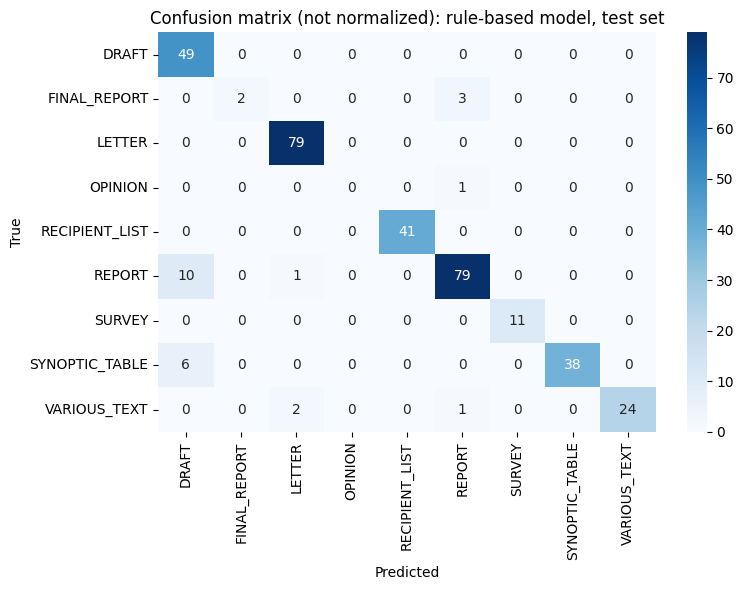

In [42]:
_y_true = y_test[y_test_predicted_rules.notna()]
_y_predicted = y_test_predicted_rules[y_test_predicted_rules.notna()]

print(sklearn.metrics.classification_report(_y_true, _y_predicted, zero_division=np.nan))
plotting.plot_confusion_matrix_heatmap(
    _y_true,
    _y_predicted,
    title="rule-based model, test set",
    # normalize="true",
)

## Display all test samples & predictions

In [43]:
df_display = df_input_test.copy()
df_display["prediction_rule"] = y_test_predicted_rules
df_display["prediction_ml"] = y_test_predicted

df_display[
    [
        "document_id",
        "political_body",
        "consultation_url",
        "document_source_url",
        "document_title",
        "document_type",
        "prediction_rule",
        "prediction_ml",
    ]
].style.format(
    {
        "consultation_url": lambda x: f'<a href="{x}">vnl</a>',
        "document_source_url": lambda x: f'<a href="{x}">doc</a>',
    }
).apply(
    lambda row: [
        f'color: {"green" if row[col] == row["document_type"] else "red"}'
        if col in {"prediction_rule", "prediction_ml"}
        else ""
        for col in row.index
    ],
    axis=1,
).set_table_styles([{"selector": "th,td", "props": [("text-align", "left")]}])

,document_id,political_body,consultation_url,document_source_url,document_title,document_type,prediction_rule,prediction_ml
47208,48198,zh,vnl,doc,Einladung zur Vernehmlassung,LETTER,LETTER,LETTER
42679,43378,lu,vnl,doc,Gesetzestext neue Bestimmungen,SYNOPTIC_TABLE,DRAFT,SYNOPTIC_TABLE
51261,52979,sh,vnl,doc,Entwurf Gesetzestext,DRAFT,DRAFT,DRAFT
52647,54518,ai,vnl,doc,Entwurf Polizeiverordnung (PolV),DRAFT,DRAFT,DRAFT
48627,49702,tg,vnl,doc,Synopse Totalrevision EG AHVG/IVG,SYNOPTIC_TABLE,SYNOPTIC_TABLE,SYNOPTIC_TABLE
52716,54592,lu,vnl,doc,Einladungsschreiben,LETTER,LETTER,LETTER
49147,50280,lu,vnl,doc,Vernehmlassungsbotschaft,REPORT,REPORT,REPORT
47258,48249,zh,vnl,doc,Erläuternder Bericht und Ergebnisbericht,REPORT,REPORT,REPORT
51755,53552,ag,vnl,doc,Umweltverträglichkeitsbericht,REPORT,nan,OPINION
46121,47097,zg,vnl,doc,Synopse Änderung des Reglements zum Schulgesetz,SYNOPTIC_TABLE,SYNOPTIC_TABLE,SYNOPTIC_TABLE


***

# End run

In [44]:
# mlflow.sklearn.log_model(
#     classifier_test,
#     artifact_path="model",
#     registered_model_name="document_type_classifier",
# )

In [45]:
mlflow.end_run()

🏃 View run rambunctious-ram-68 at: https://mlflow.ml1.demokratis.ch/#/experiments/4/runs/29e50ed39fed4b5ab6324dcf4e534b92
🧪 View experiment at: https://mlflow.ml1.demokratis.ch/#/experiments/4
